# LAA

In [1]:
!pip3 install finance-datareader==0.9.42
!pip3 install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 38.5 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        # rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 

In [4]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [5]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  # weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

In [6]:
start = "2010"
end = "2022-10-31"

In [70]:
IWM = getCloseDataPandas("IWM",start, end) 
GLD = getCloseDataPandas("GLD",start, end) 
IEF = getCloseDataPandas("IEF",start, end)  
QQQ = getCloseDataPandas("QQQ",start, end) 
SHY = getCloseDataPandas("SHY",start, end)  

SPY = getCloseDataPandas("SPY", start, end)
UNRATE = fdr.DataReader(['UNRATE'], start='2010', end='2022-10-31', data_source='fred')

closeDataSet = pd.concat([IWM, GLD, IEF,QQQ,SHY,SPY,UNRATE], axis=1)
closeDataSet.columns = ["IWM",'GLD','IEF','QQQ','SHY','SPY','UNRATE']
closeDataSet.dropna(inplace=True)
closeDataSet


,IWM,GLD,IEF,QQQ,SHY,SPY,UNRATE
2010-02-01,60.820000,108.349998,90.089996,43.259998,83.500000,109.059998,9.8
2010-03-01,64.260002,109.430000,90.550003,45.410000,83.580002,111.889999,9.9
2010-04-01,68.430000,110.260002,89.059998,48.160000,83.260002,117.800003,9.9
2010-06-01,64.239998,119.910004,92.959999,45.180000,83.769997,107.529999,9.4
2010-07-01,60.680000,117.040001,95.379997,42.590000,84.019997,102.760002,9.4
...,...,...,...,...,...,...,...
2022-04-01,207.570007,179.500000,106.650002,361.850006,83.139999,452.920013,3.6
2022-06-01,184.259995,172.229996,102.610001,306.000000,83.129997,409.589996,3.6
2022-07-01,171.410004,168.320007,103.239998,282.130005,82.959999,381.239990,3.5
2022-08-01,187.179993,165.029999,105.599998,315.269989,82.959999,410.769989,3.7


In [71]:
rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [72]:
rebalDate_year = getRebalancingDate(closeDataSet,period='year') #rebalancing_date
priceOnRebalDate_year = closeDataSet.loc[rebalDate_year] #rebal_close_data

In [80]:
weight = priceOnRebalDate.copy()
final_weight = pd.DataFrame( index = priceOnRebalDate.index, columns=priceOnRebalDate.columns)

In [84]:
final_weight['IWM'] = 0.25
final_weight['GLD'] = 0.25
final_weight['IEF'] = 0.25
weight['200']=0

In [85]:
weight

,IWM,GLD,IEF,QQQ,SHY,SPY,UNRATE,200
2010-02-01,60.820000,108.349998,90.089996,43.259998,83.500000,109.059998,9.8,0
2010-03-01,64.260002,109.430000,90.550003,45.410000,83.580002,111.889999,9.9,0
2010-04-01,68.430000,110.260002,89.059998,48.160000,83.260002,117.800003,9.9,0
2010-06-01,64.239998,119.910004,92.959999,45.180000,83.769997,107.529999,9.4,0
2010-07-01,60.680000,117.040001,95.379997,42.590000,84.019997,102.760002,9.4,0
...,...,...,...,...,...,...,...,...
2022-04-01,207.570007,179.500000,106.650002,361.850006,83.139999,452.920013,3.6,0
2022-06-01,184.259995,172.229996,102.610001,306.000000,83.129997,409.589996,3.6,0
2022-07-01,171.410004,168.320007,103.239998,282.130005,82.959999,381.239990,3.5,0
2022-08-01,187.179993,165.029999,105.599998,315.269989,82.959999,410.769989,3.7,0


In [87]:
for i in range(10, len(weight)):
  weight['200'][i] = weight['SPY'][i-10:i].sum() /10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
weight['12'] = (weight['UNRATE'].shift(1) + weight['UNRATE'].shift(2)+weight['UNRATE'].shift(3)+weight['UNRATE'].shift(4)+weight['UNRATE'].shift(5)+weight['UNRATE'].shift(6)+weight['UNRATE'].shift(7)+weight['UNRATE'].shift(8)+weight['UNRATE'].shift(9)+weight['UNRATE'].shift(10)+weight['UNRATE'].shift(11)+weight['UNRATE'].shift(12))/12


In [95]:
weight

,IWM,GLD,IEF,QQQ,SHY,SPY,UNRATE,200,12,ff
2010-02-01,60.820000,108.349998,90.089996,43.259998,83.500000,109.059998,9.8,0,NaN,1
2010-03-01,64.260002,109.430000,90.550003,45.410000,83.580002,111.889999,9.9,0,NaN,1
2010-04-01,68.430000,110.260002,89.059998,48.160000,83.260002,117.800003,9.9,0,NaN,1
2010-06-01,64.239998,119.910004,92.959999,45.180000,83.769997,107.529999,9.4,0,NaN,1
2010-07-01,60.680000,117.040001,95.379997,42.590000,84.019997,102.760002,9.4,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...
2022-04-01,207.570007,179.500000,106.650002,361.850006,83.139999,452.920013,3.6,431,5.083333,1
2022-06-01,184.259995,172.229996,102.610001,306.000000,83.129997,409.589996,3.6,438,4.825000,2
2022-07-01,171.410004,168.320007,103.239998,282.130005,82.959999,381.239990,3.5,439,4.608333,2
2022-08-01,187.179993,165.029999,105.599998,315.269989,82.959999,410.769989,3.7,435,4.400000,2


In [94]:
weight['ff'] = 0
weight['ff'] = np.where((weight['200']>weight['SPY']) & (weight['12']>weight['UNRATE']),2, 1 )

In [96]:
final_weight['QQQ'] = np.where(weight['ff']==1,0.25,0)
final_weight['SHY'] = np.where(weight['ff']==2,0.25,0)

In [99]:
closeDataSet = closeDataSet.drop(['SPY','UNRATE'] , axis=1)

In [102]:
final_weight =final_weight.drop(['SPY','UNRATE'] , axis=1)

In [103]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet,weightDf=final_weight)
cagr, dd, mdd = getEvaluation(CumReturn)

최종 수익률: 2.935242013803152
cagr: 14.682321136169563
mdd: 11.884089242485228


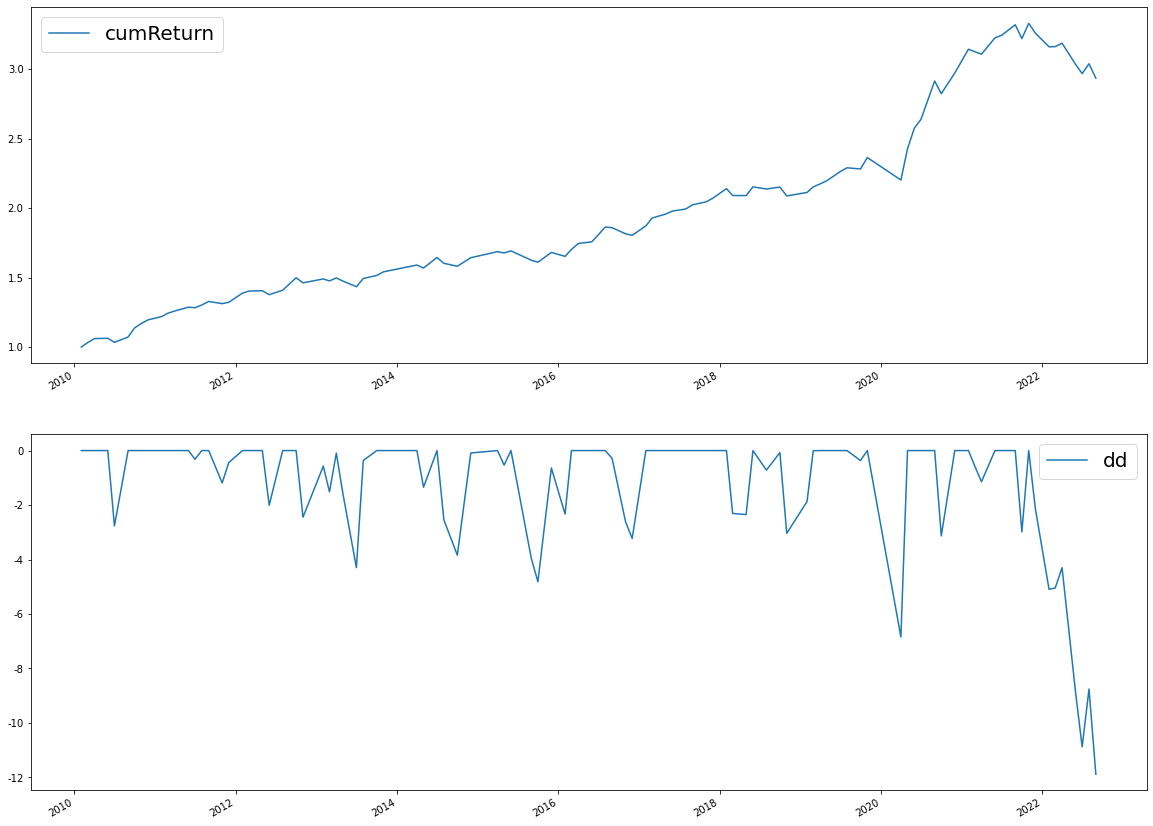

In [104]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="cumReturn")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label="dd")
plt.legend(fontsize=20)

plt.show()